In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
PATH = r'/Users/teguhsatya/Desktop/moiOneHundred'

In [3]:
retina = {}
ACCEPT = ('jpg', 'png', 'JPG', 'JPEG')
for files in os.listdir(PATH):
    print(f'reading {os.path.join(PATH, files)}')
    if files.split('.')[1] in ACCEPT:
        fname = files.split('.')[0]
        retina[fname] = cv2.imread(os.path.join(PATH, files))
        retina[fname] = cv2.cvtColor(retina[fname], cv2.COLOR_BGR2RGB)


reading /Users/teguhsatya/Desktop/moiOneHundred/348.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/228.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/229.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/407.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/349.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/439.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/377.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/362.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/389.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/160.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/158.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/366.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/.DS_Store
reading /Users/teguhsatya/Desktop/moiOneHundred/213.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/429.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/398.jpg
reading /Users/teguhsatya/Desktop/moiOneHundred/159.jpg
reading /Users/teguhsatya/Desktop/moiOneHundre

In [4]:
def display_all(imgs, subs=(10,10), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(18, 21))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            # axs[i, j].axis('off')
            k+=1
            
def display_all_with(imgs, cc, subs=(10,10), use_gray=True):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(18, 21))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k][:,:,cc], cmap='gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def adjust_gamma(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

In [5]:
cropped = {}
for img in retina:
    cropped[img] = retina[img][400:1800, 400:2600]

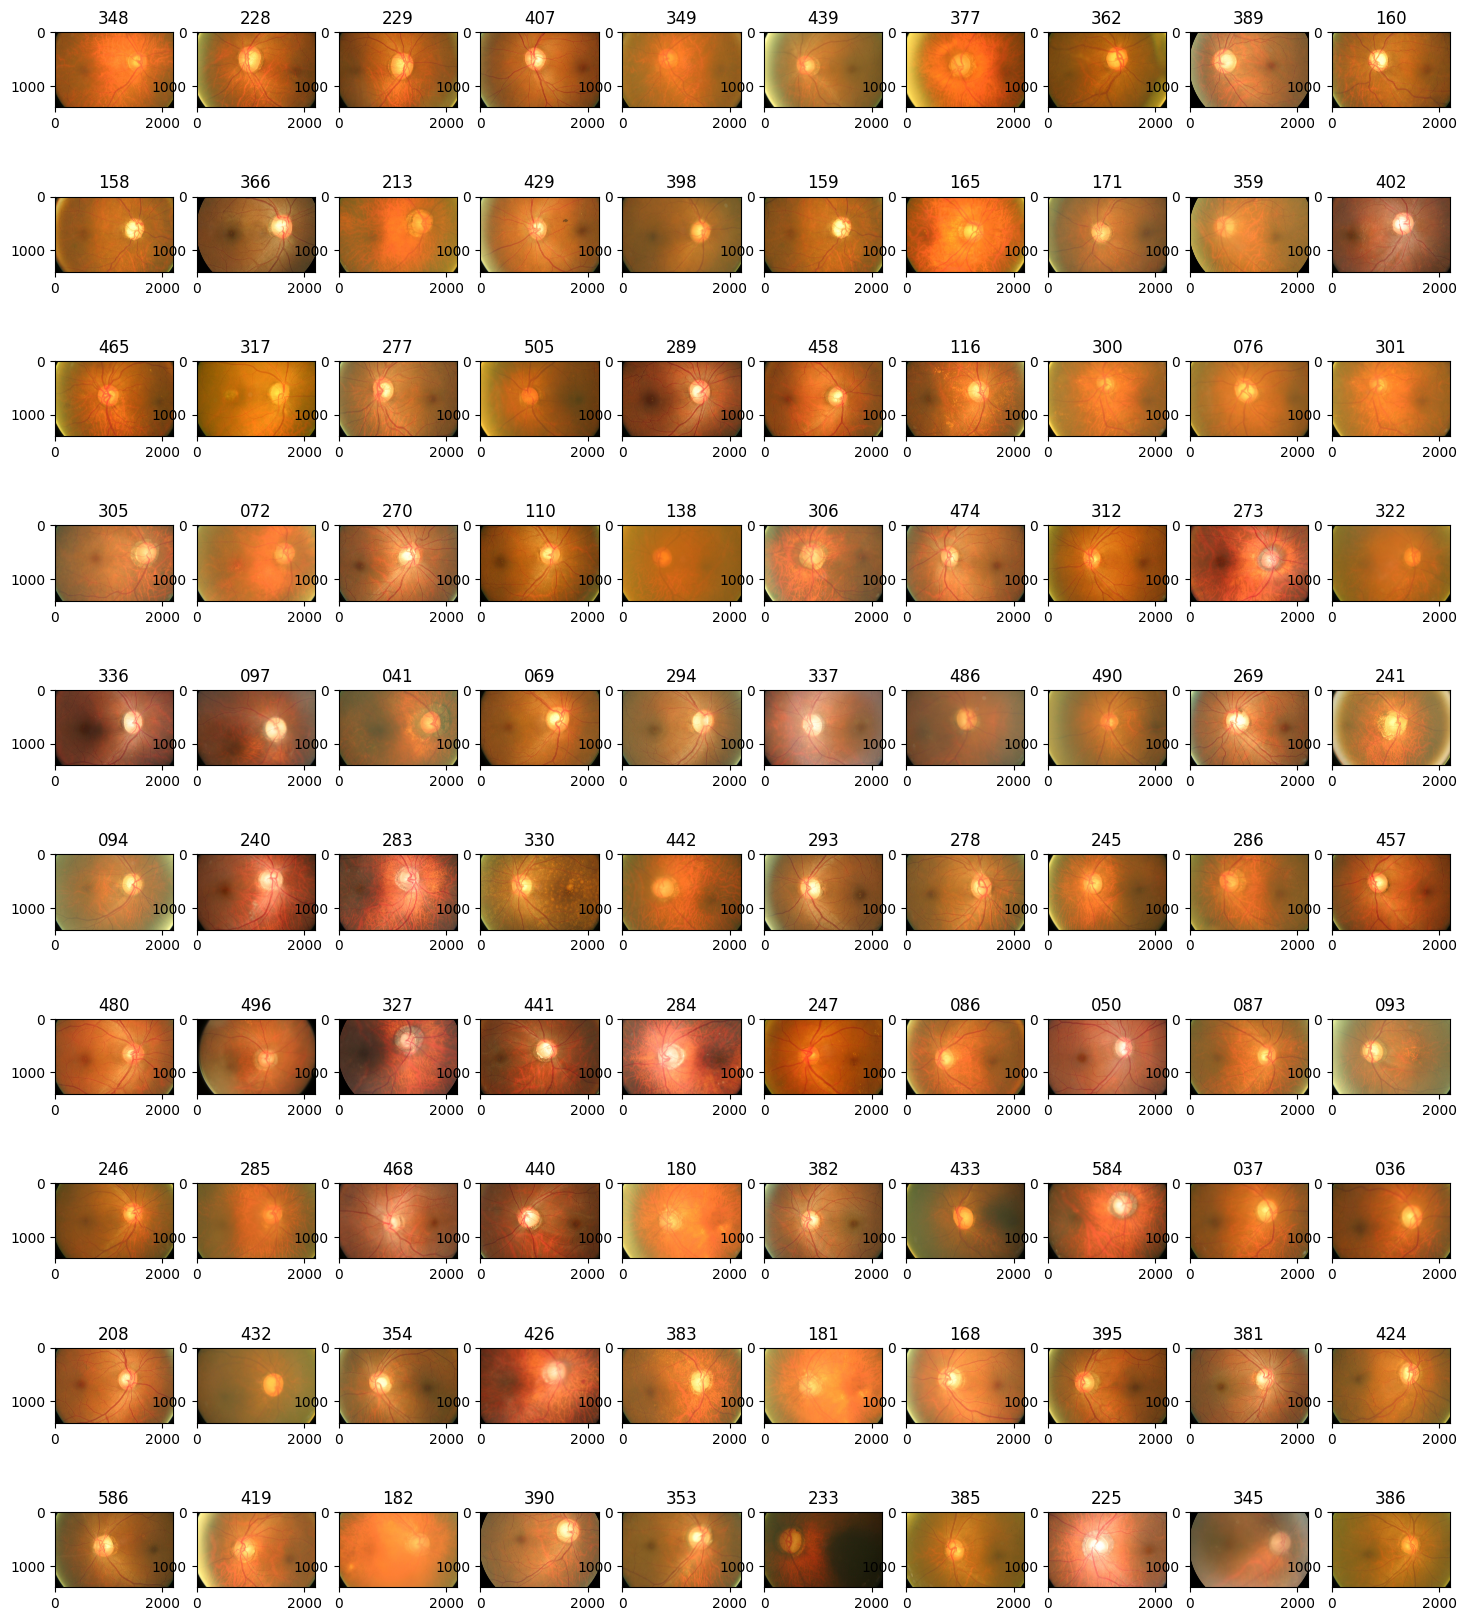

In [6]:
display_all(cropped)

In [7]:
def preprocess(imgs):
    lab = cv2.cvtColor(imgs, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(1.5, (50, 50))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def vignettify(img, kernel=(900, 900)):
    row, cols = img.shape
    cols_kernel = cv2.getGaussianKernel(cols, kernel[0])
    rows_kernel = cv2.getGaussianKernel(row, kernel[1])
    masked = rows_kernel*cols_kernel.T
    masked_res = masked/masked.max()
    vignette = img*masked
    return vignette

def get_roi(imgs):
    p = {}
    for img in imgs:
        pre = preprocess(imgs[img])
        gray = cv2.cvtColor(pre, cv2.COLOR_RGB2GRAY)
        vignette = vignettify(gray)
        blur = cv2.blur(vignette, (35, 35))
        xmax = cv2.minMaxLoc(vignette)[3][0]
        ymax = cv2.minMaxLoc(vignette)[3][1]
        cropped = Image.fromarray(imgs[img])
        cropped_res = cropped.crop((xmax-400, ymax-400, xmax+400, ymax+400))
        p[img] = np.array(cropped_res)
    return p
        
    # display_all(p, use_gray=False)

In [8]:
rois = get_roi(cropped)

# Optic Disc Begin!

In [71]:
def get_od(imgs):
    pr = {}
    clahe = cv2.createCLAHE(1, (25,25))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55,55)) # 35,35 sounds like a good idea
    ckernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55,55))
    for img in imgs:
        lab = cv2.cvtColor(imgs[img], cv2.COLOR_RGB2LUV)
        lab[:,:,0] = adjust_gamma(lab[:,:,0], 3.5)
        rgb = cv2.cvtColor(lab, cv2.COLOR_LUV2RGB)
        rgb[:,:,0] = adjust_gamma(rgb[:,:,0], 4)
        # rgb[:,:,1] = adjust_gamma(rgb[:,:,0], 2)
        xyz = cv2.cvtColor(rgb, cv2.COLOR_RGB2XYZ)
        # xyz[:,:,0] = clahe.apply(xyz[:,:,0])
        blurred = cv2.GaussianBlur(xyz[:,:,0], (5, 5), 0)
        # pr[img] = cv2.morphologyEx(xyz[:,:,0], cv2.MORPH_OPEN, kernel)
        closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, ckernel)
        # eroded = cv2.erode(opened, (75, 75))
        ret2,pr[img] = cv2.threshold(closed,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        
    display_all(pr, use_gray=True)
        
    # display_all_with(pr, 0, use_gray=True)
    
    
def get_od_super(imgs):
    sample = {}
    clahe = cv2.createCLAHE(2.0, (100,100))
    for img in imgs:
        hsv = cv2.cvtColor(imgs[img], cv2.COLOR_RGB2HSV)
        hsv[:,:,2] = clahe.apply(hsv[:,:,2])
        rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        sample[img] = cv2.medianBlur(rgb, 45)
        # sample[img] = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    # display_all(sample, use_gray=True)
    display_all_with(sample, 0, use_gray=True)
        
        

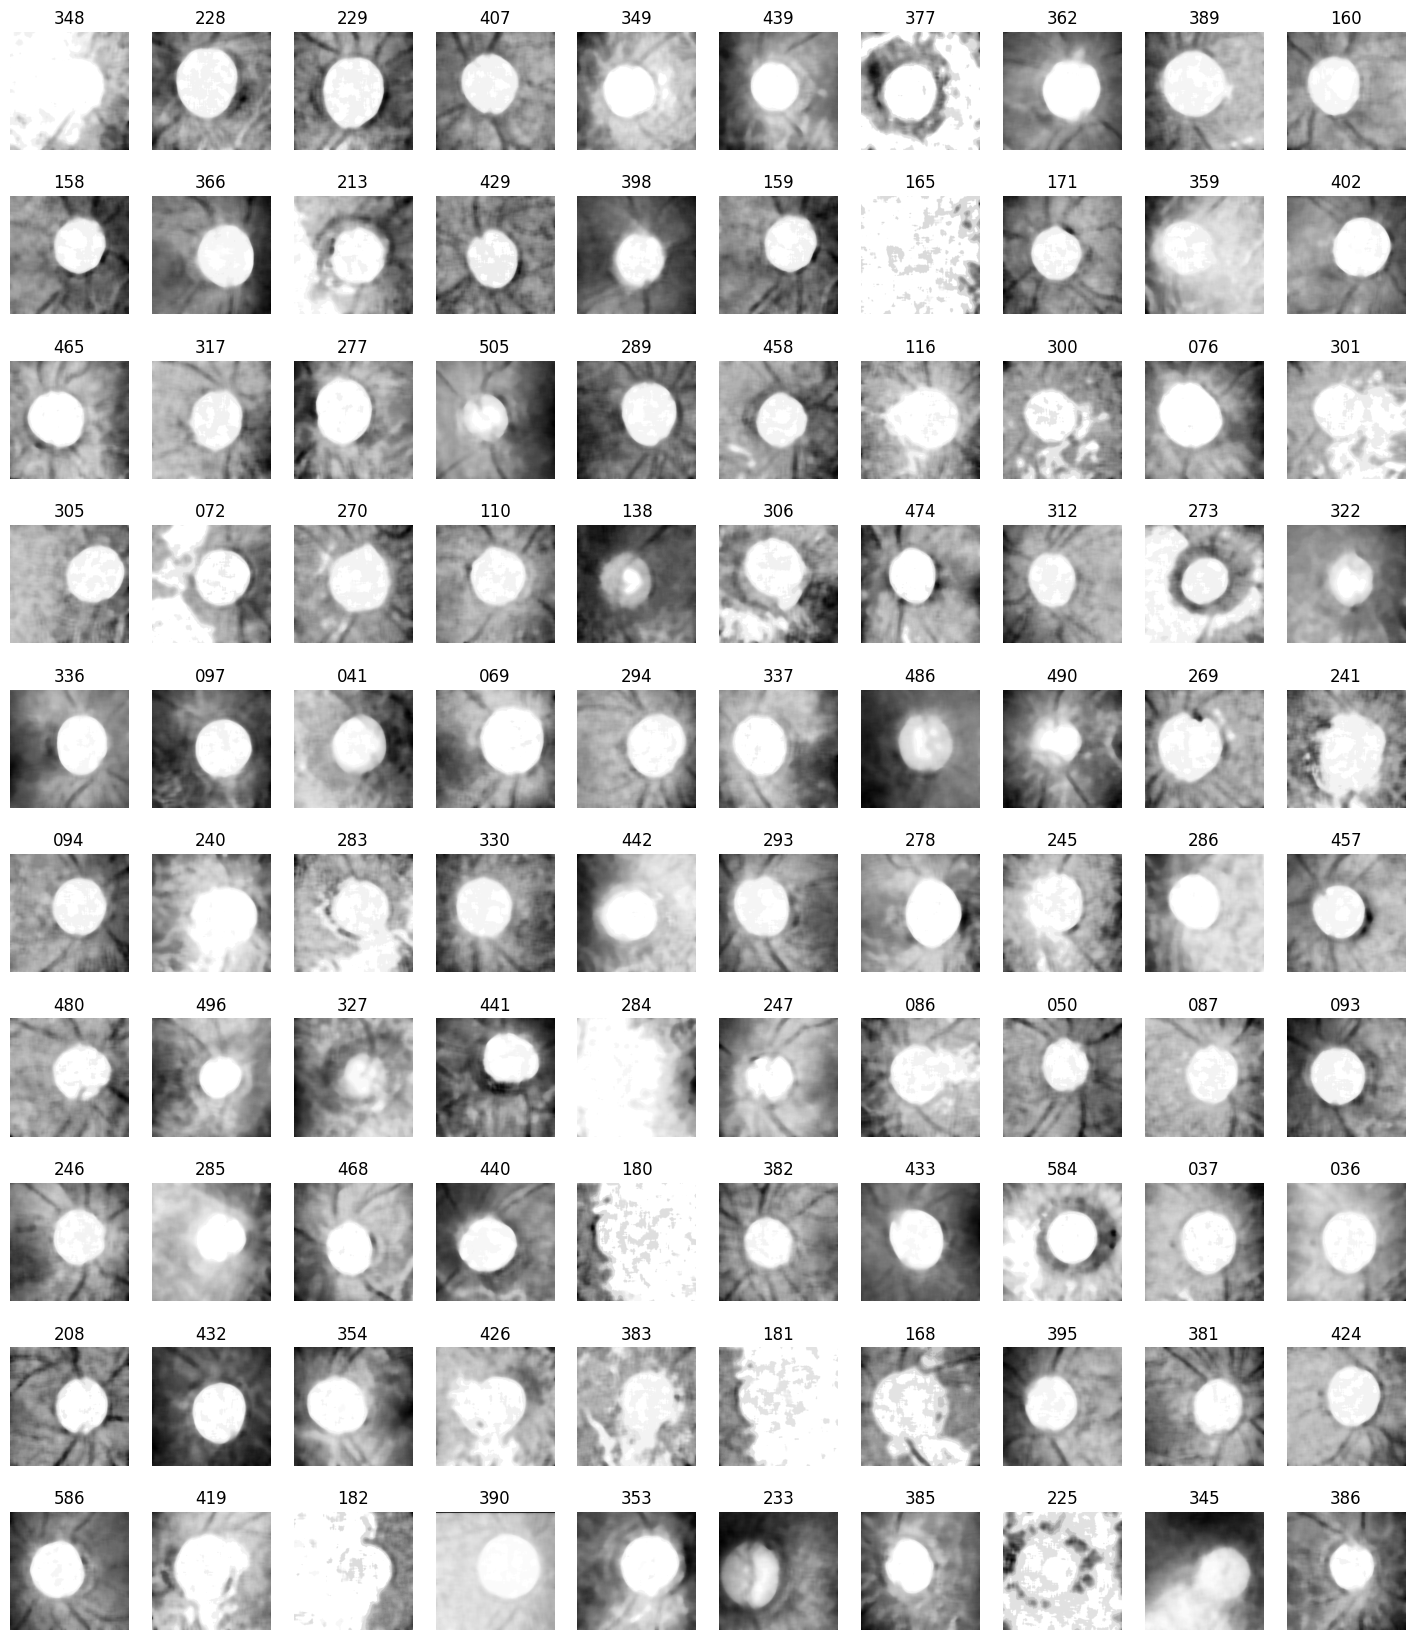

In [72]:
ods = get_od_super(rois)